# Libraries:

In [39]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, StackingRegressor
from sklearn.metrics import mean_absolute_error

# 1. Creation of the plot:

In [40]:
ticker_symbol = "DX-Y.NYB"
ticker = yf.Ticker(ticker_symbol)
df = ticker.history(period="5y").reset_index(drop=False)
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2020-11-06 00:00:00-05:00,92.570000,92.820000,92.180000,92.230003,0,0.0,0.0
1,2020-11-09 00:00:00-05:00,92.239998,92.959999,92.129997,92.730003,0,0.0,0.0
2,2020-11-10 00:00:00-05:00,92.760002,92.970001,92.599998,92.750000,0,0.0,0.0
3,2020-11-11 00:00:00-05:00,92.699997,93.209999,92.610001,93.040001,0,0.0,0.0
4,2020-11-12 00:00:00-05:00,93.010002,93.139999,92.779999,92.959999,0,0.0,0.0
...,...,...,...,...,...,...,...,...
1253,2025-10-31 00:00:00-04:00,99.489998,99.839996,99.419998,99.800003,0,0.0,0.0
1254,2025-11-03 00:00:00-05:00,99.750000,99.989998,99.709999,99.870003,0,0.0,0.0
1255,2025-11-04 00:00:00-05:00,99.980003,100.260002,99.739998,100.220001,0,0.0,0.0
1256,2025-11-05 00:00:00-05:00,100.180000,100.360001,100.059998,100.199997,0,0.0,0.0


# Removal of unnecessary columns

In [41]:
df = df.drop(columns=["Volume", "Dividends", "Stock Splits"], errors='ignore')

# Creation of the plot:

In [42]:
fig = px.line(df,
              x="Date",
              y=["Open", "High", "Low", "Close"],
              title="USD Dollar Index - 5 Years",
              labels={"value": "Variable (USD)", "Date": "Date", "variable": "Type of the Variable"},
              width=1000, height=600)

fig.update_layout(legend_title_text="Variable")
fig.show()

# 2. Evaluation of the graph:

I note that the time series in the graph are not static but change over time, i.e. they fluctuate. In other words, the dollar exchange rates change over time.

# 3. Problems in training models on non-static time series

I believe that one problem was that it does not have the accuracy we want for this model. In other words, because prices change over time, the model will not be able to learn well from past prices and thus will not be able to predict future prices well, especially if there are many fluctuations.

# 5. Predicting the "Close" viarable

Predicting the "Close" viarable for the next day based solely on today's characteristics (open, high, low, close) is very difficult, I believe, because time series are non-static and are influenced by many factors.

# 6. Train-Test split

I believe that there is no reason to divide the data into train and test. One reason is that the data series is time-dependent, i.e., I believe that each day depends on the previous one. And the prediction must be made using the previous data, with the past, so we should not randomly separate the data, but rather the train should have the older data and the other the newer data.

# 7. Split of the data in train–test dataframes

In [43]:
train_df = df[df['Date'] < '2024-01-01'].copy()
test_df = df[(df['Date'] >= '2024-01-01') & (df['Date'] < '2025-01-01')].copy()

print(f"Train size: {train_df.shape}")
print(f"Test size: {test_df.shape}")


train_df = train_df.drop(columns=['Date'])
test_df = test_df.drop(columns=['Date'])


train_df.head()

Train size: (791, 5)
Test size: (252, 5)


,Open,High,Low,Close
0,92.570000,92.820000,92.180000,92.230003
1,92.239998,92.959999,92.129997,92.730003
2,92.760002,92.970001,92.599998,92.750000
3,92.699997,93.209999,92.610001,93.040001
4,93.010002,93.139999,92.779999,92.959999


# 8. Creating a Function for Timeframes

In [44]:
def create_timeframes(df, N=5):

    X, y = [], []
    values = df[['Open', 'High', 'Low', 'Close']].values

    for i in range(len(values) - N):
        X.append(values[i:i+N])
        y.append(values[i+N][3])

    return np.array(X), np.array(y)

In [45]:
N = 5

X_train, y_train = create_timeframes(train_df, N)
X_test, y_test = create_timeframes(test_df, N)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


print("\n (5x4):")
print(X_train[0])
print("The target:", y_train[0])

X_train shape: (786, 5, 4)
y_train shape: (786,)
X_test shape: (247, 5, 4)
y_test shape: (247,)

 (5x4):
[[92.56999969 92.81999969 92.18000031 92.23000336]
 [92.23999786 92.95999908 92.12999725 92.73000336]
 [92.76000214 92.97000122 92.59999847 92.75      ]
 [92.69999695 93.20999908 92.61000061 93.04000092]
 [93.01000214 93.13999939 92.77999878 92.95999908]]
The target: 92.76000213623047


# 9. Select Timeframe size


If we want to predict the next day, N should be relatively small, e.g. 3.5, while if we want to predict further ahead, we need a larger N. This is because, in the first case, recent days have a greater influence on the short-term future. In order to look further into the future, we need to know more about the general trend and not just the last few days.

# 10. Creation of x_train, y_train, x_test, y_test with N = 5

In [59]:
N = 5

X_train, y_train = create_timeframes(train_df, N)
X_test, y_test = create_timeframes(test_df, N)

X_train = X_train.reshape(X_train.shape[0], N*4)
X_test  = X_test.reshape(X_test.shape[0], N*4)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

print("\nFirst input x_train (20 elements):")
print(X_train[0])


X_train shape: (786, 20)
y_train shape: (786,)
X_test shape: (247, 20)
y_test shape: (247,)

First input x_train (20 elements):
[92.56999969 92.81999969 92.18000031 92.23000336 92.23999786 92.95999908
 92.12999725 92.73000336 92.76000214 92.97000122 92.59999847 92.75
 92.69999695 93.20999908 92.61000061 93.04000092 93.01000214 93.13999939
 92.77999878 92.95999908]


# 11. The different models creation

Linear Regression

In [53]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_train_lr = lr.predict(X_train)
y_test_lr  = lr.predict(X_test)
mae_train_lr = mean_absolute_error(y_train, y_train_lr)
mae_test_lr  = mean_absolute_error(y_test, y_test_lr)

Random Forest

In [52]:
rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)
y_train_rf = rf.predict(X_train)
y_test_rf  = rf.predict(X_test)
mae_train_rf = mean_absolute_error(y_train, y_train_rf)
mae_test_rf  = mean_absolute_error(y_test, y_test_rf)


Bagging Regression

In [56]:
bag = BaggingRegressor(estimator=LinearRegression(), n_estimators=10, random_state=0)
bag.fit(X_train, y_train)
y_train_bag = bag.predict(X_train)
y_test_bag  = bag.predict(X_test)
mae_train_bag = mean_absolute_error(y_train, y_train_bag)
mae_test_bag  = mean_absolute_error(y_test, y_test_bag)

estimators = [
    ('lr', LinearRegression()),
    ('dt', DecisionTreeRegressor(max_depth=5, random_state=0))
]

Stacking Regression

In [57]:
stack = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
stack.fit(X_train, y_train)
y_train_stack = stack.predict(X_train)
y_test_stack  = stack.predict(X_test)
mae_train_stack = mean_absolute_error(y_train, y_train_stack)
mae_test_stack  = mean_absolute_error(y_test, y_test_stack)


MAE

In [58]:
mae_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Bagging LR', 'Stacking LR+DT'],
    'MAE_Train': [mae_train_lr, mae_train_rf, mae_train_bag, mae_train_stack],
    'MAE_Test': [mae_test_lr, mae_test_rf, mae_test_bag, mae_test_stack]
})
print(mae_df)

x = np.arange(len(mae_df['Model']))
width = 0.35



               Model  MAE_Train  MAE_Test
0  Linear Regression   0.345752  0.284560
1      Random Forest   0.147382  0.325000
2         Bagging LR   0.346769  0.284656
3     Stacking LR+DT   0.350491  0.288100


# Plot creation

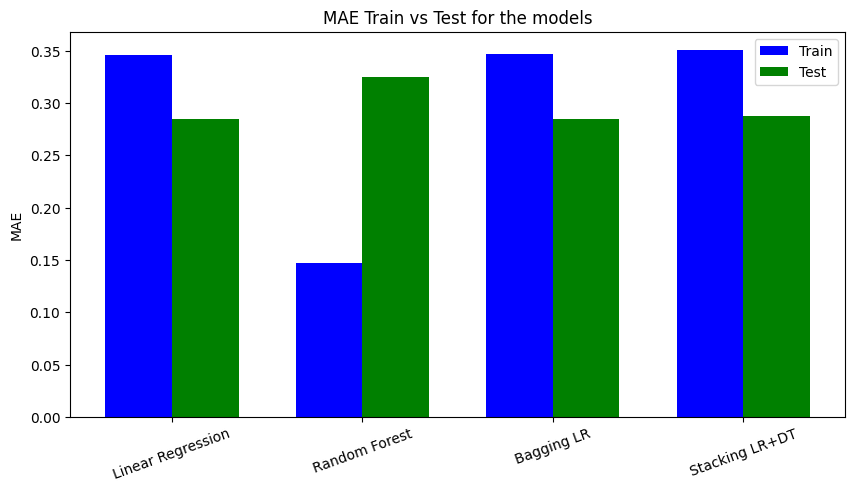

In [48]:
plt.figure(figsize=(10,5))
plt.bar(x - width/2, mae_df['MAE_Train'], width, label='Train', color='blue')
plt.bar(x + width/2, mae_df['MAE_Test'], width, label='Test', color='green')
plt.xticks(x, mae_df['Model'], rotation=20)
plt.ylabel('MAE')
plt.title('MAE Train vs Test for the models')
plt.legend()
plt.show()

# 12a. Addition of Month and Date

In [49]:
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day

df.head()

,Date,Open,High,Low,Close,Month,Day
0,2020-11-06 00:00:00-05:00,92.570000,92.820000,92.180000,92.230003,11,6
1,2020-11-09 00:00:00-05:00,92.239998,92.959999,92.129997,92.730003,11,9
2,2020-11-10 00:00:00-05:00,92.760002,92.970001,92.599998,92.750000,11,10
3,2020-11-11 00:00:00-05:00,92.699997,93.209999,92.610001,93.040001,11,11
4,2020-11-12 00:00:00-05:00,93.010002,93.139999,92.779999,92.959999,11,12


I believe that the month and day will contribute positively to the forecasts because there will be more data and will allow the model to learn better from the recurring patterns that will exist.

# 12b,c Application of Logarithmic Returns

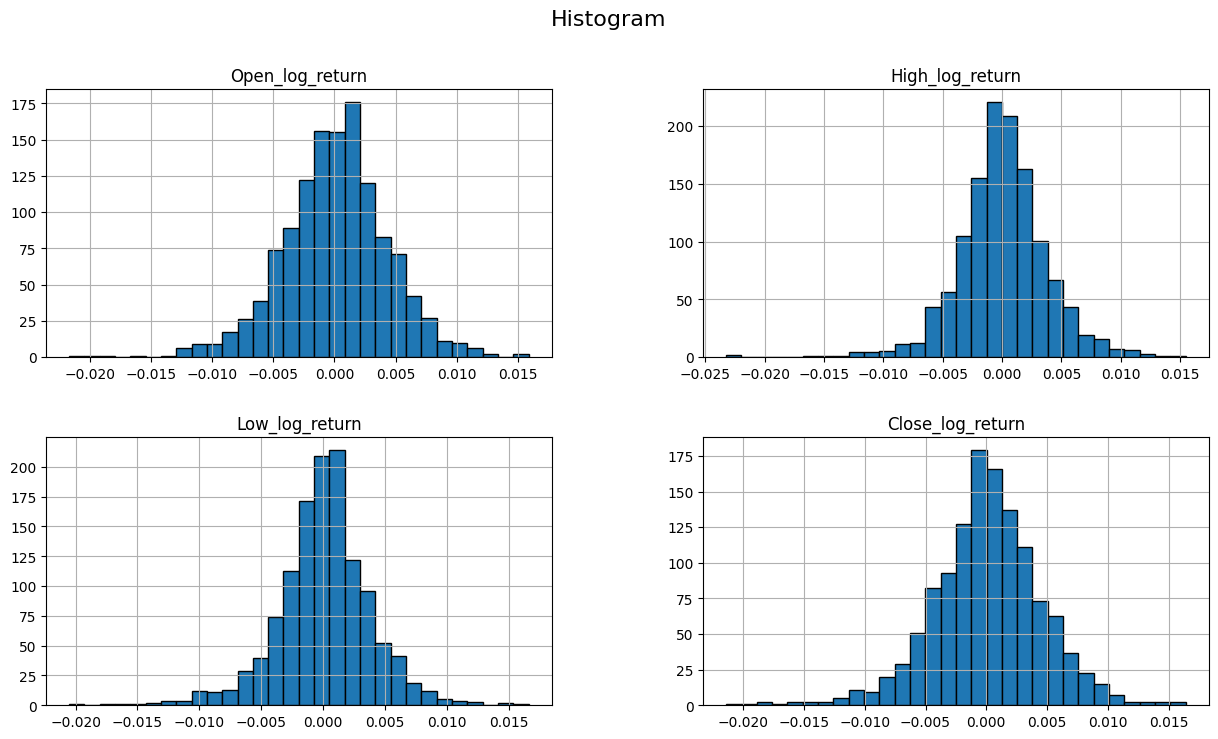

In [50]:
cols = ['Open', 'High', 'Low', 'Close']

for col in cols:
    df[col + '_log_return'] = np.log(df[col] / df[col].shift(1))

df = df.dropna().reset_index(drop=True)

df[[c + '_log_return' for c in cols]].hist(bins=30, figsize=(15,8), edgecolor='black')
plt.suptitle("Histogram", fontsize=16)
plt.show()